# Standardize the sdss slime fit to the bp slime

This method uses the wasserstein distance to scale the sdss distribution to that of the Bolshoi-Planck slime fit density distribution. There are mismatches in the density of the two distributions, likely due to the fact that 
the sdss fits are missing lower mass galaxies compared to the fits on the simulation. Thus we need to visually inspect the standardization of the distribution. The slime mold folder NEED to be made with float32!!!

Ref:
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wasserstein_distance.html

In [1]:
%matplotlib inline
%matplotlib inline
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
import numpy as np
from pyslime import utils as pu
import pyslime.pipeline.pipelineUtils as ppu

#import jax.numpy as jnp
# from jax import pmap, jit, vmap

# All the data live here (except the simulation binaries):
datadir = "/Volumes/GoogleDrive/My Drive/SlimeMold/2021-11-23-VACv2/"
dropboxdir = "/Users/mwilde/Dropbox/slime-mold/data/final_data/"
packagedir = "/Users/mwilde/python/"

# slime fit to the BP simulations
bpslimedir = datadir + "BP_z=0.0"
bpslime_datafile = "trace.bin"

sdss_slime_dir = datadir + 'SDSS_z=44-476mpc'
sdss_datafile = 'trace.bin'


## Load the nonstandardized data and flatten it

In [2]:
nostd_sdss_slime32 = pu.get_slime(sdss_slime_dir, datafile=sdss_datafile, dtype=np.float32, standardize=False)
nostd_bpslime32 = pu.get_slime(bpslimedir, datafile=bpslime_datafile, dtype=np.float32, standardize=False)
nostd_flatbpslime = nostd_bpslime32.data.ravel()
nostd_flatsdssslime = nostd_sdss_slime32.data.ravel()

/Users/mwilde/python/pyslime/pyslime/utils.py:331: RuntimeWarning: divide by zero encountered in log10
  slimeobj.data = np.log10(slimeobj.data)


## convert the data into distributions U & V

We are going to do a linear transform on the sdss data to shape it closer to the the BP data distribution

    NOTE: U = BPslime
          V = SDSS_slime
The data need to be visually inspected to determin where to cut the data to ignore the low-density regime where 
the two distributions are not expected to match. 

We can see from above that densities less than 0.5 are very different due to the "empty" space in the sdss fits

In [5]:
bpmin = nostd_flatbpslime[~np.isinf(nostd_flatbpslime)].min()
sdssmin = nostd_flatsdssslime[~np.isinf(nostd_flatsdssslime)].min()

In [6]:
# create histograms
bins = np.linspace(bpmin, np.max(nostd_flatbpslime), 100)
sbins = np.linspace(sdssmin, np.max(nostd_flatsdssslime), 100)

uweights, uvalues = ppu.get_hist(nostd_flatbpslime, 100)# , bins=bins)
vweights, vvalues = ppu.get_hist(nostd_flatsdssslime, 100)# , bins=sbins)

TypeError: get_hist() got an unexpected keyword argument 'bins'

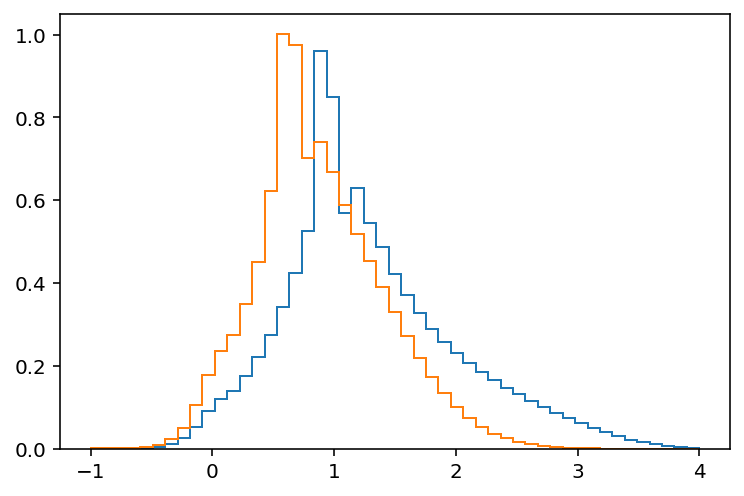

In [8]:
# create histograms
bins = np.linspace(-1, 4, 50)
plt.hist(nostd_flatsdssslime, bins, histtype='step', density=True, label='sdss');
plt.hist(nostd_flatbpslime, bins, histtype='step', density=True, label='bp');

## the peaks in the distributions are NOT where we see the structure (filaments etc). The right tail is the density of galaxy halos

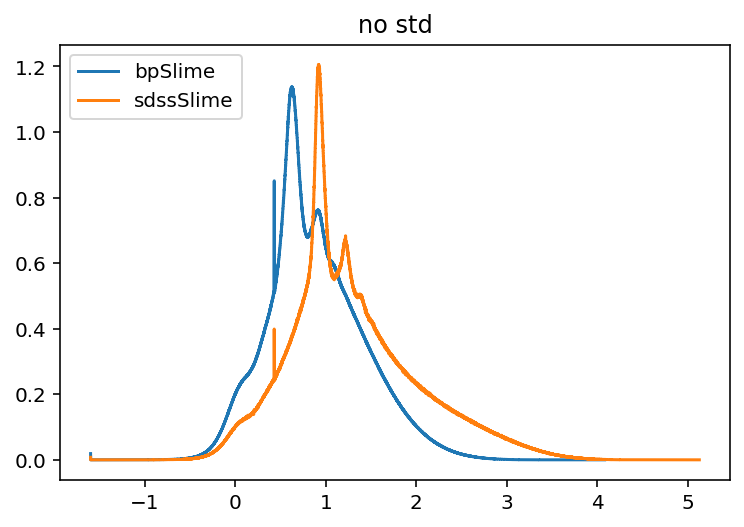

In [12]:
# plt.figure(figsize=(10,7))
plt.step(uvalues, uweights, label="bpSlime")
plt.step(vvalues, vweights, label="sdssSlime")
plt.legend(loc='upper left')
plt.title("no std");

In [13]:
# density cut
dens_thresh = -1

# since we are fixing the bp (u_values)
denscut = uvalues > dens_thresh
uweights_cut = uweights[denscut]
uvalues_cut = uvalues[denscut]

# dont do the cut here
vdenscut = vvalues > -1
vweights_cut = vweights[vdenscut]
vvalues_cut = vvalues[vdenscut]

# now implement the linear transform and search over a grid to find the optimal value of the `stretch` and `shift` parameters

In [14]:
stretch, shift  = ppu._calc_stretch_shift(
    uvalues_cut,
    vvalues_cut,
    uweights_cut,
    vweights_cut,
    stretchmin=0.5,
    strectmax=1,
    shiftmin=-1,
    shiftmax=1,
    denscut=-10
)

In [15]:
stretch, shift

(array([0.75114116]), array([-0.07563025]))

## Verify the linear transform lines up the right side of the distributions. I found that the peaks dont correspond to dense structure, so ignore them for now. 

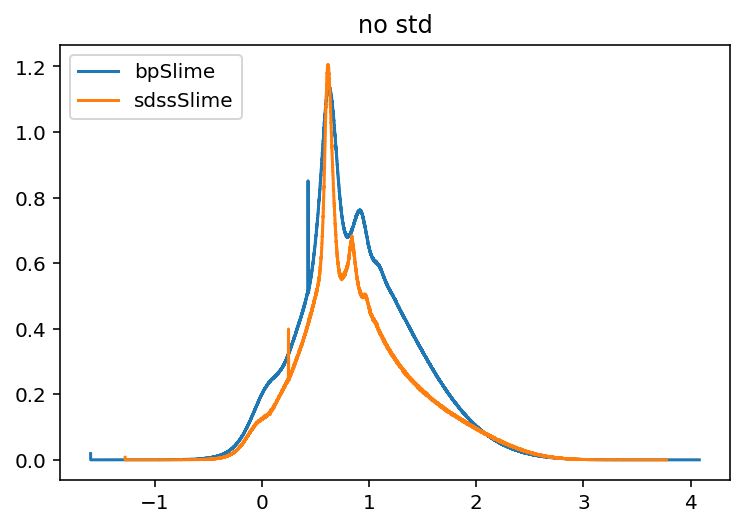

In [16]:
newvals = vvalues*stretch + shift
# plt.figure(figsize=(10,7))
plt.step(uvalues, uweights, label="bpSlime")
plt.step(newvals, vweights, label="sdssSlime")
plt.legend(loc='upper left')
plt.title("no std");


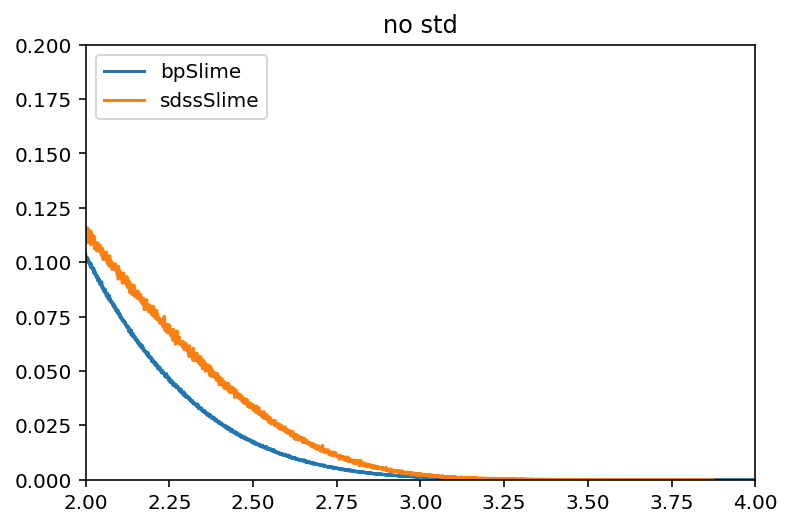

In [17]:
newvals = vvalues*stretch + shift
# plt.figure(figsize=(10,7))
plt.step(uvalues, uweights, label="bpSlime")
plt.step(newvals+0.1, vweights, label="sdssSlime")
plt.legend(loc='upper left')
plt.xlim(2,4)
plt.ylim(0,0.2)
plt.title("no std");

In [18]:
newvals.max(), nostd_flatsdssslime.max(), np.max(nostd_flatsdssslime*stretch +shift)

(3.7756453722107532, 5.127569, 3.7758980318747426)

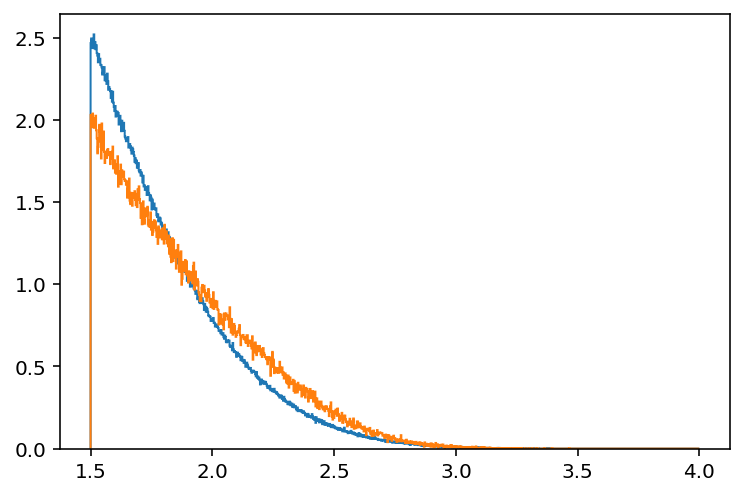

In [19]:
bins = np.linspace(1.5, 4, 1000)
kwargs = {"bins":bins, "histtype":"step", "density":True}

plt.hist(nostd_flatbpslime[::50], **kwargs, label='raw')

newdist = nostd_flatsdssslime*stretch + shift
plt.hist(newdist[::50], **kwargs, label='newStd');

# what is the max value of the transformed dist? likely around Coma or someother structure. 

In [20]:
newdist.max()

3.7758980318747426

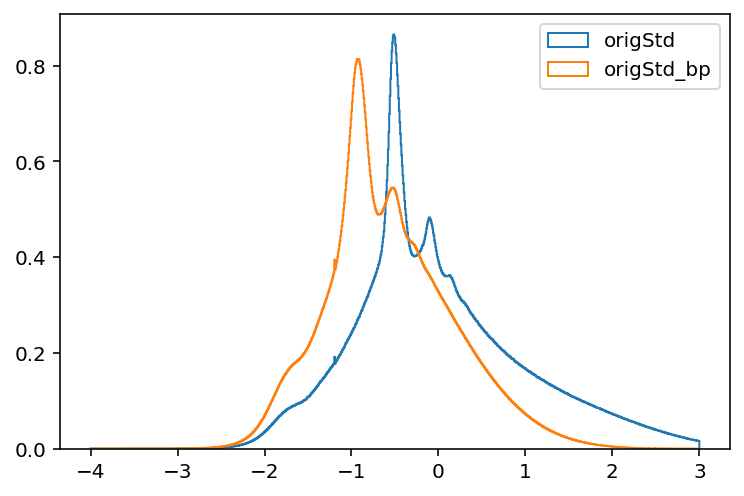

In [21]:
bins = np.linspace(-4, 3, 1000)
kwargs = {"bins":bins, "histtype":"step", "density":True}
# try the old method:
dat = nostd_flatsdssslime[~np.isinf(nostd_flatsdssslime)]
olddist = (dat - np.nanmean(dat))/np.nanstd(dat)
plt.hist(olddist, **kwargs, label='origStd');
# plt.legend()

# try the old method:
datbp = nostd_flatbpslime[~np.isinf(nostd_flatbpslime)]
olddistbp = (datbp - np.nanmean(dat))/np.nanstd(dat)
plt.hist(olddistbp, **kwargs, label='origStd_bp');
plt.legend()

In [ ]:
newdist.max()

3.503223777975221

In [ ]:
stretch, shift

(array([0.65027082]), array([0.28571429]))

In [ ]:
(nostd_flatsdssslime*stretch+ shift).max()

3.634971256148467

In [ ]:
nostd_bpslime32.data.max()

4.0386014

In [ ]:
nostd_flatsdssslime.max()

5.150557

In [ ]:
dndrho, bin_edges = np.histogram(nostd_flatbpslime, bins=bins)

In [ ]:
binmids = 0.5*bin_edges[:-1] + 0.5*bin_edges[1:]
maxidx = dndrho == dndrho.max()
binmids[maxidx]

array([0.74924925])